In [1]:
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
# Algorithms
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, r2_score
import sqlite3
from datetime import datetime
import matplotlib.dates as mdates


In [2]:
def requete_sql (requete) :
    try:
        connexion = sqlite3.connect('./data/liste_piezos.db')
        curseur = connexion.cursor()
        print("Connexion réussie à SQLite")
        curseur.execute(requete)
        connexion.commit()
        resultat = curseur.fetchall()
        curseur.close()
        connexion.close()
        print("Connexion SQLite est fermée")
        return resultat
    except sqlite3.Error as error:
        print("Erreur lors du mis à jour dans la table", error)

# Import des données
## Sélection des piezos

Récupération des codes_bss par jointure de tables dans la base de données

In [3]:
region = "BRE"

requete = f"""
        SELECT code_bss
        FROM data_piezo
        INNER JOIN code_region
            ON code_dpt = departement
        WHERE code_region IS '{region}'
        AND fichier_piezo IS 1
         """
data = requete_sql(requete)
code_bss = []
for code in data:
    code_bss.append(code[0]) 

Connexion réussie à SQLite
Connexion SQLite est fermée


In [4]:
code_bss

['02388X0060_F1',
 '03851X0021_S2',
 '03454X0070_F',
 '03128X0011_F',
 '02442X0111_F',
 '03822X0021_F',
 '03113X0031_F',
 '02465X0061_F',
 '03493X0013_F',
 '02451X0023_F',
 '03114X0023_F',
 '03462X0043_F',
 '03885X0034_F',
 '04184X0035_F',
 '02431X0106_F',
 '03514X0106_F',
 '03871X0016_F',
 '02408X0016_F',
 '03546X0017_F',
 '03152X0027_F',
 '03107X0008_F',
 '03124X0088_F',
 '02394X0019_F',
 '03506X0059_F',
 '03884X0021_TF1PR',
 '02396X0030_PZ',
 '03843X0021_PZ',
 '03514X0081_PZ',
 '03486X0022_PZ',
 '02478X0122_PZ',
 '02761X0032_PZ',
 '03506X0032_PZ',
 '02047X0072_PZ',
 '02034X0082_PZ',
 '03101X0023_PZ',
 '03535X0043_PZ',
 '02794X0063_PZ',
 '02796X0044_PZ',
 '04173X0045_PZ',
 '02835X0055_PZ',
 '02413X0065_PZ',
 '03137X0026_PZ',
 '02803X0036_PZ',
 '03516X0036_PZ',
 '02385X0046_PZ',
 '02478X0156_PZ',
 '03182X0027_PZ',
 '02782X0047_PZ',
 '03103X0047_PZ',
 '03862X0057_PZ',
 '02812X0238_PZ',
 '03175X0338_PZ',
 '03172X0088_PZ',
 '03473X0029_PZ',
 '03162X0049_PZ',
 '03834X0049_PZ']

## Construction d'un dataframe

In [7]:
directory = './data/piezo/'

# Lecture des données du premier piezo de la liste pour initialiser le dataframe
data = pd.read_csv(directory+f"{code_bss[0]}.csv", sep=";",  index_col=0, parse_dates=True)
data.rename(columns={"piezo":f"{code_bss[0]}"}, inplace=True)

custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")

for file in code_bss[1:]:
    df = pd.read_csv(f"{directory+file}.csv", sep=";",  index_col=0, parse_dates=True, date_parser=custom_date_parser)
    df.rename(columns={"piezo":f"{file}"}, inplace=True)
    data = pd.merge(data,df,left_index=True, right_index=True,how='outer')

In [8]:
data

,02388X0060_F1,03851X0021_S2,03454X0070_F,03128X0011_F,02442X0111_F,03822X0021_F,03113X0031_F,02465X0061_F,03493X0013_F,02451X0023_F,...,03182X0027_PZ,02782X0047_PZ,03103X0047_PZ,03862X0057_PZ,02812X0238_PZ,03175X0338_PZ,03172X0088_PZ,03473X0029_PZ,03162X0049_PZ,03834X0049_PZ
date_mesure,,,,,,,,,,,,,,,,,,,,,
1980-02-01,NaN,NaN,NaN,-8.35,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-02-02,NaN,NaN,NaN,-8.09,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-02-03,NaN,NaN,NaN,-7.81,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-02-04,NaN,NaN,NaN,-7.47,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-02-05,NaN,NaN,NaN,-7.16,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Visualisation des valeurs manquantes

In [9]:
# Fonction d'affichage des valeurs manquantes
def f_plot_nan (dataframe):
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,6))
    sns.heatmap(dataframe.T.isna(), cmap='Blues', cbar=False)
    ax.set_title('Missing Values', fontsize=16)
    # Masquage des noms de piezo 
    ax.yaxis.set_visible(False)
    # Formatage de la date pour l'affichage
    ax.xaxis.set_ticklabels([pd.to_datetime(value).strftime('%Y') for value in ax.xaxis.get_major_formatter().func.args[0].values()])
    plt.show()

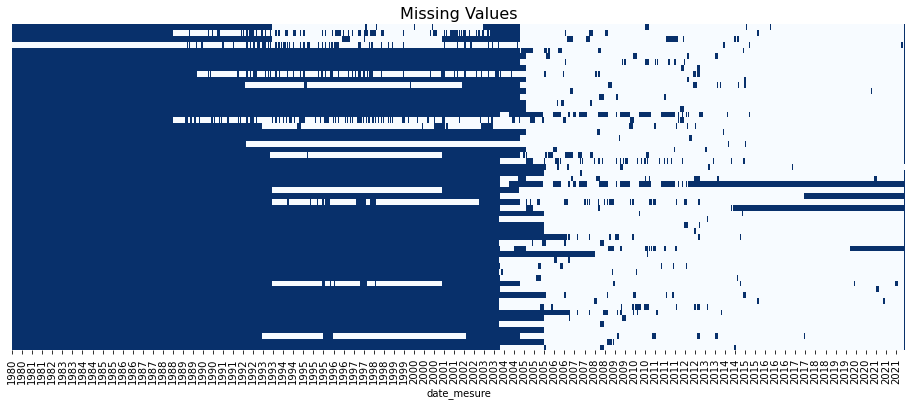

In [10]:
f_plot_nan(data)

# Traitement des données

## Rééchantillonnage à la semaine

In [11]:
data_week = pd.DataFrame(data.resample('7D').mean())

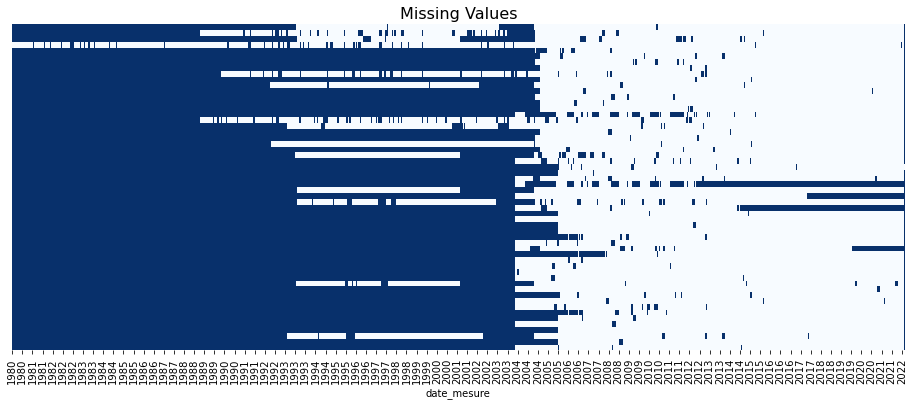

In [12]:
f_plot_nan(data_week)

In [13]:
data_week.shape

(2208, 56)

## Echelle de temps fixée après 2006 pour limiter les Nan

In [28]:
data_week_from_ = data_week.loc['01-01-2006':]

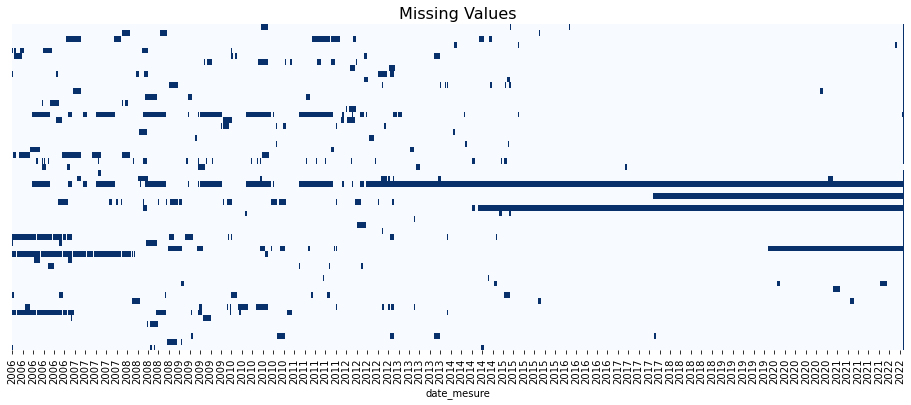

In [29]:
f_plot_nan(data_week_from_)

## Suppression des valeurs abbérantes
Utilisation de la méthode IQR pour supprimer les valeurs abbérantes.
- Calcul des quartiles et de l'écart interquartile
- Suppression des valeurs < Q1 - 1.5*IQR
- Suppression des valeurs > Q3 + 1.5*IQR

In [30]:
nbre_na = data_week_from_.isna().sum().sum()
print(f"Il y a à ce stade {nbre_na} valeurs nulles dans l'ensemble du dataframe.")

Il y a à ce stade 2709 valeurs nulles dans l'ensemble du dataframe.


In [31]:
data_wo_outliers = data_week_from_.copy()

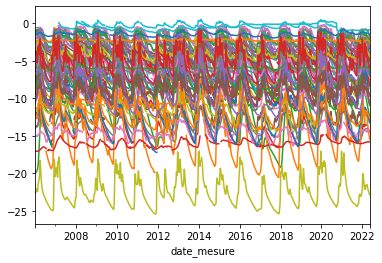

In [32]:
for piezo in data_wo_outliers.columns : 
    q1 = np.nanquantile(data_wo_outliers[f"{piezo}"], .25)
    q3 = np.nanquantile(data_wo_outliers[f"{piezo}"], .75)
    IQR = q3-q1
    data_wo_outliers.loc[data_wo_outliers[f"{piezo}"] < (q1-1.5*IQR), piezo] = np.NaN
    data_wo_outliers.loc[data_wo_outliers[f"{piezo}"] > (q3+1.5*IQR), piezo] = np.NaN
    data_wo_outliers[f"{piezo}"].plot()

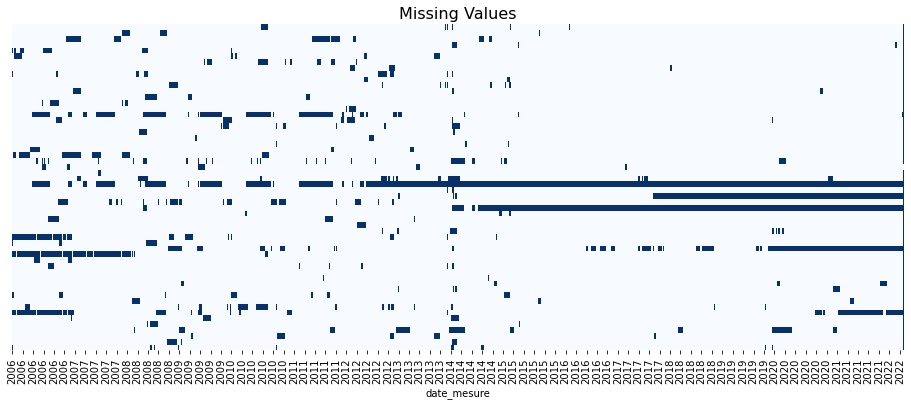

In [33]:
f_plot_nan(data_wo_outliers)

In [34]:
nbre_na_2 = data_wo_outliers.isna().sum().sum()
print(f"Il y a à ce stade {nbre_na_2} valeurs nulles dans l'ensemble du dataframe.")

Il y a à ce stade 3048 valeurs nulles dans l'ensemble du dataframe.


## Suppression des piezos avec plus de 5% de valeurs manquantes

In [35]:
# Liste des piezos avec plus de 10% de valeurs manquantes
bss_to_drop = data.loc[:,data_wo_outliers.isna().sum()>0.05*data_wo_outliers.shape[0]].columns

In [36]:
data_clean = data_wo_outliers.copy().drop(bss_to_drop, axis=1)

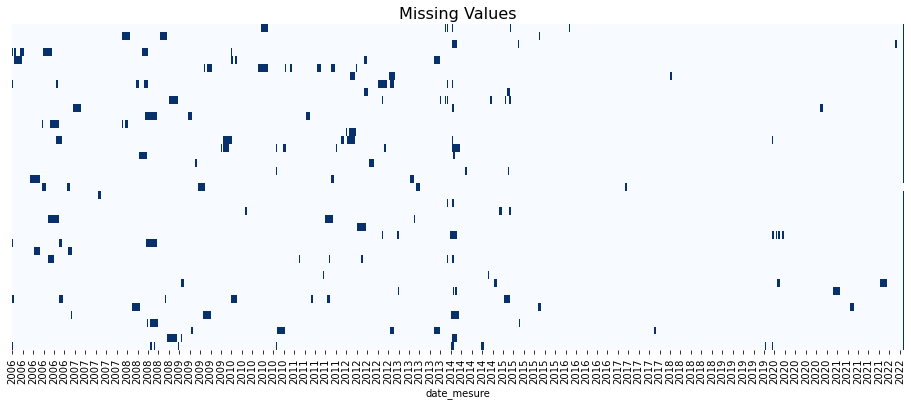

In [37]:
f_plot_nan(data_clean)

In [38]:
nbre_na_3 = data_clean.isna().sum().sum()
print(f"Il y a à ce stade {nbre_na_3} valeurs nulles dans l'ensemble du dataframe.")

Il y a à ce stade 592 valeurs nulles dans l'ensemble du dataframe.


In [39]:
data_clean.shape

(855, 41)

## Interpolation

In [40]:
data_interpol = data_clean.copy().interpolate('linear')

In [41]:
data_interpol.shape

(855, 41)

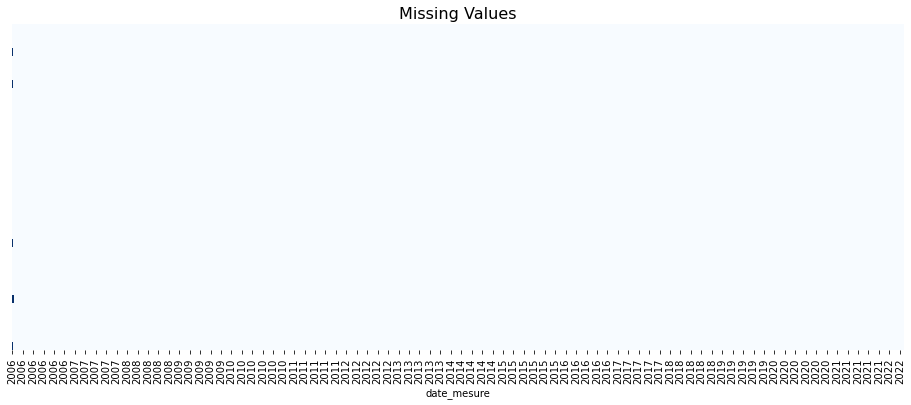

In [42]:
f_plot_nan(data_interpol)

## Réajustement des dates de début et de fin

In [43]:
debut = []
for column in data_interpol.columns:
    debut.append(data_interpol[f"{column}"].first_valid_index())
date_debut = max(debut)

In [44]:
fin = []
for column in data_interpol.columns:
    fin.append(data_interpol[f"{column}"].last_valid_index())
date_fin = min(fin)
date_fin

Timestamp('2022-05-20 00:00:00', freq='7D')

In [45]:
data_interpol = data_interpol.loc[date_debut:date_fin]

In [46]:
print(f"Nombre total de Nan : {data_interpol.isna().sum().sum()}")

Nombre total de Nan : 0


In [47]:
data_interpol.shape

(853, 41)

In [48]:
data_interpol.shape[1]

41

## Affichage des chroniques après nettoyage

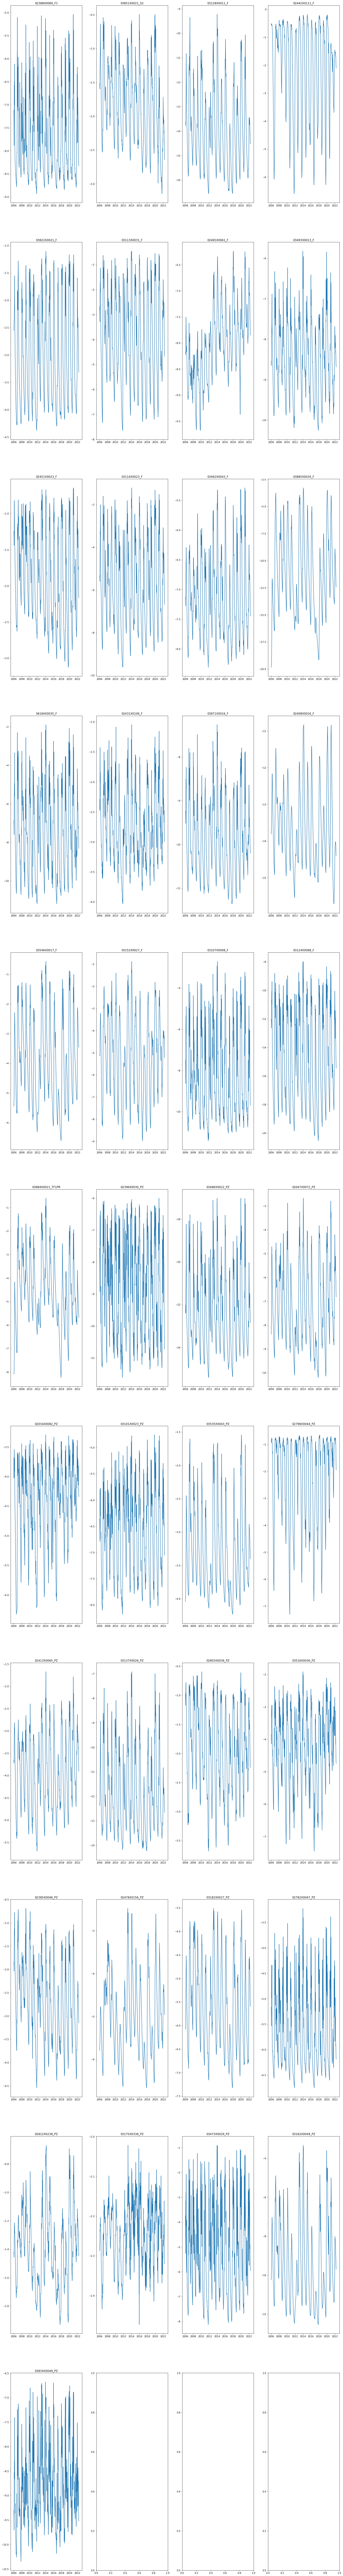

In [49]:
if data_interpol.shape[1]%4 == 0:
    nbre_lignes = data_interpol.shape[1]//4
else : 
    nbre_lignes = data_interpol.shape[1]//4 + 1

fig, axs = plt.subplots(nbre_lignes,4,figsize=(25,200))
#fig.suptitle('Series')
for i in range(nbre_lignes):
    for j in range(4):
        if i*4+j+1>data_interpol.shape[1]: # pass the others that we can't fill
            continue
        axs[i, j].plot(data_interpol.iloc[:,i*4+j])
        axs[i, j].set_title(data_interpol.columns[i*4+j])
plt.show()

## Normalisation StandardScaler

Comme il n'y a visuellement pas de valeurs abbérantes qui sautent aux yeux, la normalisation choisie est la standardisation

In [50]:
def scaleColumns(df):
    for col in df.columns:
        df[col] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df[col])),columns=[col], index=df.index)
    return df

In [51]:
scaler = StandardScaler()
data_norm = scaleColumns(data_interpol.copy())

In [52]:
data_norm.head()

,02388X0060_F1,03851X0021_S2,03128X0011_F,02442X0111_F,03822X0021_F,03113X0031_F,02465X0061_F,03493X0013_F,02451X0023_F,03114X0023_F,...,03516X0036_PZ,02385X0046_PZ,02478X0156_PZ,03182X0027_PZ,02782X0047_PZ,02812X0238_PZ,03175X0338_PZ,03473X0029_PZ,03162X0049_PZ,03834X0049_PZ
date_mesure,,,,,,,,,,,,,,,,,,,,,
2006-01-20,0.658914,0.526053,0.169825,0.950007,0.499597,0.665846,-0.222744,-0.070120,1.039233,0.227962,...,0.379038,0.955195,-0.892088,-0.528267,0.583768,-0.080365,-0.512820,0.743463,-0.376552,-0.624151
2006-01-27,0.363335,0.479615,0.174166,0.929495,0.563040,0.561676,-0.196393,-0.091688,0.944469,0.194607,...,0.346306,0.876787,-0.806224,-0.499743,0.400064,-0.138699,-0.327946,0.344695,-0.294208,-0.795232
2006-02-03,0.026878,0.433176,0.123817,0.908982,0.626483,0.453676,-0.249095,-0.147150,0.840680,0.145965,...,0.222652,0.790212,-0.757828,-0.481727,0.312759,-0.186427,-0.327946,0.099907,-0.252373,-1.019775
2006-02-10,-0.185373,0.391626,0.086489,0.912828,0.689925,0.338016,-0.277472,-0.191827,0.734634,0.095237,...,0.132941,0.734673,-0.742216,-0.442694,0.112685,-0.212942,-0.180046,-0.095134,-0.211865,-1.123137
2006-02-17,0.563008,0.834014,0.186319,0.914270,0.753368,0.635973,-0.161935,0.430571,1.147535,0.303011,...,0.806981,1.259026,-0.703187,-0.140934,0.878422,0.221911,0.171214,1.064846,-0.105615,0.341743


## Sauvegarde du dataframe en csv

In [53]:
data_norm.to_csv(f"./data/piezo_clustering/{region}.csv", sep = ";")